In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from safe_control_gym.lyapunov.lyapunov import *
from safe_control_gym.lyapunov.utilities import *

from safe_control_gym.experiments.arxiv.utils.gpmpc_plotting_utils import *

/home/tumeilsy-mo-10/anaconda3/envs/safe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print('notebook_dir', notebook_dir)
data_folder = '../data/cartpole_data_eff/'
data_folder_path = os.path.join(notebook_dir, data_folder)
print('data_folder_path', data_folder_path)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
s = 2 # times of std

notebook_dir /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils
data_folder_path /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/


In [3]:
class benchmark_cost_data:
    # data stored in the path like "prior/seed/figs/"
    # each data is a csv file
    def __init__(self, data_folder_path, controller_name, prior_name):
        self.data_folder_path = data_folder_path
        self.controller_name = controller_name
        self.prior_name = prior_name
        self.controller_data_folder_path = os.path.join(data_folder_path, controller_name)
        self.prior_data_folder_path = os.path.join(self.controller_data_folder_path, prior_name)
        self.none_count = 0
        self.early_stop = 0
        self.max_seed = None
        self.check_data_folder()
        self.find_all_seed_folders()
        self.append_figs_to_seeds()
        self.load_csv_cost_data_all_seeds()
        self.early_stop_ratio = self.early_stop / self.max_seed

    def check_data_folder(self):
        if not os.path.exists(self.prior_data_folder_path):
            print('prior data folder does not exist')
            return False
        print(f'prior data {self.prior_name} folder exists')
        return True
    
    def find_all_seed_folders(self):
        # find all folder name in the prior data folder
        self.seed_folders = [f for f in os.listdir(self.prior_data_folder_path) \
                        if os.path.isdir(os.path.join(self.prior_data_folder_path, f))]
        # get the number between 'seed' and '_'
        seed_list = [int(f.split('seed')[1].split('_')[0]) for f in self.seed_folders]
        sorted_seed_folders = [x for _, x in sorted(zip(seed_list, self.seed_folders))]
        self.seed_folders = sorted_seed_folders
        self.max_seed = np.max(seed_list)
        print('max seed', self.max_seed)
    
    def append_figs_to_seeds(self):
        # append 'figs' to the end of seed_folders
        self.seed_folders = [os.path.join(self.prior_data_folder_path, f) for f in self.seed_folders]
        self.seed_folders = [os.path.join(f, 'figs') for f in self.seed_folders]
    
    def load_csv_cost_data(self, seed):
        # load the csv file in the seed folder
        # return the data in the csv file
        seed_folder = self.seed_folders[seed-1]
        csv_file = os.path.join(seed_folder, 'common_cost_learning_curve.csv')
        # if the file does not exist, return None
        if not os.path.exists(csv_file):
            print(f'csv file for seed {seed} does not exist')
            self.none_count += 1
            return None
        data = np.genfromtxt(csv_file, delimiter=',')
        return data

    def load_csv_cost_data_all_seeds(self):
        # load all csv files in the seed folders
        # return the data in the csv files
        self.data_all_seeds = []
        for seed in range(len(self.seed_folders)):
            data = self.load_csv_cost_data(seed)
            self.data_all_seeds.append(data)
        all_epoch = [0 for _ in range(len(self.seed_folders))]
        for data in self.data_all_seeds:
            if data is not None:
                all_epoch.append(data.shape[0])
        self.sim_epoch = np.max(all_epoch)
        print('sim_epoch', self.sim_epoch)
        for i, data in enumerate(self.data_all_seeds):
            if data is not None:
                if data.shape[0] < self.sim_epoch:
                    self.early_stop += 1
                    print(f'seed {i} early stop with epoch {data.shape[0]}')
            elif data is None:
                self.early_stop += 1
                print(f'seed {i} early stop with epoch 0')
        # pop out the data with None and early stop
        self.merged_data = []
        for data in self.data_all_seeds:
            if data is not None and data.shape[0] == self.sim_epoch:
                self.merged_data.append(data)
        
    def get_mean_std(self):
        # get the mean and std of the data
        self.mean_data = np.mean(self.merged_data, axis=0)
        self.std_data = np.std(self.merged_data, axis=0)
        # round the first column of mean to integer
        self.mean_data[:, 0] = np.round(self.mean_data[:, 0])
        # leave out the first colum of the std
        self.std_data = self.std_data[:, 1:]
        self.std_data = self.std_data.squeeze()
        return self.mean_data, self.std_data
        

In [14]:
controller_name = 'gp_mpc'
# get the default pyplot color cycle

prior_list = [
              # 'M_0.1',
              'M_0.5', 
              'M_1.0', 
              'M_1.5', 
              'M_2.0', 
              'M_3.0']
# prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)

# M_100 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_0.1')
M_500 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_0.5')
M_1000 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_1.0')
M_1000_reduced = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_1.0_reduced_init')
M_1500 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_1.5')
M_2000 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_2.0')
# M_2500 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_2.5')
M_3000 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_3.0')

    
# test_data = M_500.merged_data
# # print('test_data', test_data)
# mean, std = M_500.get_mean_std()
# print('mean', mean)
# print('std', std)
# print('none count', M_500.none_count)


prior data M_0.5 folder exists
max seed 15
csv file for seed 7 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 1 early stop with epoch 3
seed 7 early stop with epoch 0
seed 10 early stop with epoch 2
seed 12 early stop with epoch 4
seed 13 early stop with epoch 4
seed 14 early stop with epoch 0
prior data M_1.0 folder exists
max seed 15
sim_epoch 6
prior data M_1.5 folder exists
max seed 15
sim_epoch 6
seed 0 early stop with epoch 4
prior data M_2.0 folder exists
max seed 15
csv file for seed 2 does not exist
sim_epoch 6
seed 2 early stop with epoch 0
seed 3 early stop with epoch 2
seed 13 early stop with epoch 2
prior data M_3.0 folder exists
max seed 15
csv file for seed 2 does not exist
csv file for seed 8 does not exist
sim_epoch 6
seed 2 early stop with epoch 0
seed 8 early stop with epoch 0
seed 12 early stop with epoch 2
prior data M_0.5 folder exists
max seed 15
csv file for seed 7 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 1 early s

Text(0.5, 1.0, 'Cartpole GP-MPC Cost Learning Curve')

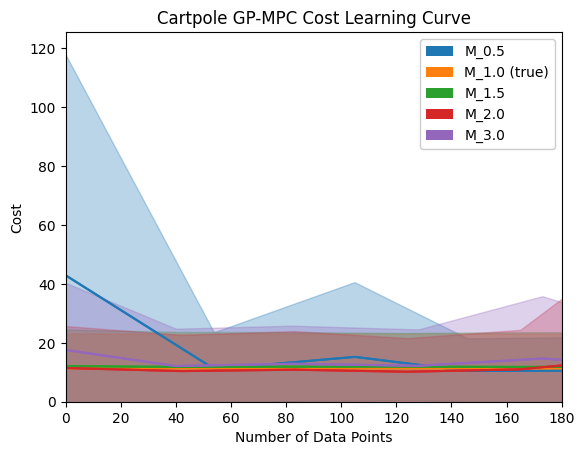

In [15]:
# plot the mean and std

for i, data in enumerate(data_list):
    mean, std = data.get_mean_std()
    plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
    plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
    plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                     color=colors[i])
# create the legend for each prior
ax = plt.gca()
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]   
for i in range(len(prior_list)):
    if prior_list[i] == 'M_1.0':
        prior_list[i] = 'M_1.0 (true)'
legend = ax.legend(proxy, prior_list, loc='upper right')
legend.get_frame().set_alpha(1.)
# limit the y axis to 0- 100
plt.ylim(0, None)
plt.xlim(0, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole GP-MPC Cost Learning Curve')
# use log y scale
# ax.set_yscale('log')

# plt.legend()

mean [[  0.          28.13360781]
 [ 43.          28.12925022]
 [ 86.          28.12652035]
 [129.          28.12425774]
 [172.          28.12010354]
 [215.          28.11896499]]
std [1.96525392 1.96380443 1.96330171 1.96204032 1.96172246 1.96114443]


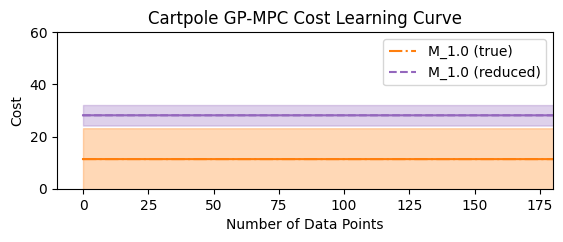

In [6]:
# mean, std = M_500.get_mean_std()
# plt.plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[0])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[0])
# mean, std = M_1500.get_mean_std()
# plt.plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[2])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[2])
# mean, std = M_3000.get_mean_std()
# plt.plot(mean[:, 0], mean[:, 1], label='M_3.0', color=colors[3], marker='x')
# plt.plot(mean[:, 0], mean[:, 1], color=colors[3])
# plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                  color=colors[3])
mean, std = M_1000.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
plt.plot(mean[:, 0], mean[:, 1], color=colors[1])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[1])
mean, std = M_1000_reduced.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.0 (reduced)', color=colors[4], linestyle='--')
plt.plot(mean[:, 0], mean[:, 1], color=colors[4])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[4])
print('mean', mean)
print('std', std)
ax = plt.gca()
# limit the y axis to 0- 100
# plt.ylim(0, None)
plt.ylim(0, 60)
plt.xlim(-10, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole GP-MPC Cost Learning Curve')
plt.legend()
# change the plot ratio to 4:3
ax.set_aspect(aspect=1.0)

In [7]:
# save the cost mean and std to npy file
mean, std = M_500.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]


data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_0.5_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)
print(f'save data to {data_file_path}')

mean, std = M_1000.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]
data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_1.0_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)
print(f'save data to {data_file_path}')

mean, std = M_3000.get_mean_std()
data_amount = mean[:, 0]
mean = mean[:, 1]

data = {'mean': mean, 'std': std, 'data_amount': data_amount}
data_file_name = 'gp_mpc_M_3.0_cost.npy'
data_file_path = os.path.join(data_folder_path, data_file_name)
np.save(data_file_path, data)

print(f'save data to {data_file_path}')




save data to /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/gp_mpc_M_0.5_cost.npy
save data to /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/gp_mpc_M_1.0_cost.npy
save data to /home/tumeilsy-mo-10/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/gp_mpc_M_3.0_cost.npy


prior data M_0.1 folder exists
max seed 15
csv file for seed 2 does not exist
csv file for seed 3 does not exist
csv file for seed 4 does not exist
csv file for seed 6 does not exist
csv file for seed 7 does not exist
csv file for seed 8 does not exist
csv file for seed 9 does not exist
csv file for seed 10 does not exist
csv file for seed 12 does not exist
csv file for seed 13 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 2 early stop with epoch 0
seed 3 early stop with epoch 0
seed 4 early stop with epoch 0
seed 5 early stop with epoch 2
seed 6 early stop with epoch 0
seed 7 early stop with epoch 0
seed 8 early stop with epoch 0
seed 9 early stop with epoch 0
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 12 early stop with epoch 0
seed 13 early stop with epoch 0
seed 14 early stop with epoch 4
prior data M_0.5 folder exists
max seed 15
csv file for seed 7 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 1 early stop with epoc

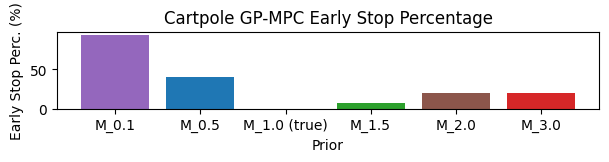

In [8]:
# plot the early stop percentage
plt.figure(figsize=(7, 1))
max_seed = M_500.max_seed


# prior_list = ['M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_3.0']
# for i, data in enumerate(data_list):
#     print(f'prior {prior_list[i]} early stop percentage: {data.early_stop_ratio}')
#     plt.bar(prior_list[i], data.early_stop_ratio * 100, color=colors[i])

# prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)
prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
plt.bar(prior_list[0], data_list[0].early_stop_ratio * 100, color=colors[4]) # M_0.1
plt.bar(prior_list[1], data_list[1].early_stop_ratio * 100, color=colors[0]) # M_0.5
plt.bar(prior_list[2], data_list[2].early_stop_ratio * 100, color=colors[1]) # M_1.0
plt.bar(prior_list[3], data_list[3].early_stop_ratio * 100, color=colors[2]) # M_1.5
plt.bar(prior_list[4], data_list[4].early_stop_ratio * 100, color=colors[5]) # M_2.0
plt.bar(prior_list[5], data_list[5].early_stop_ratio * 100, color=colors[3]) # M_3.0
plt.xlabel('Prior')
plt.ylabel('Early Stop Perc. (%)')
plt.title('Cartpole GP-MPC Early Stop Percentage')

ax=plt.gca()
# change the plot ratio to 4:3
# ax.set_aspect(aspect=3.0)
# save the figure
plt.savefig('cartpole_gp_mpc_early_stop.png', dpi=300)




In [9]:
# controller_name = 'sqp_gp_mpc'
# # get the default pyplot color cycle

# prior_list = [
#                 'M_0.1',
#                 'M_0.5', 
#                 'M_1.0', 
#                 'M_1.5', 
#                 'M_2.0', 
#                 'M_3.0']
# # prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
# data_list = []
# for prior in prior_list:
#     data = benchmark_cost_data(data_folder_path, controller_name, prior)
#     data_list.append(data)

# # M_100 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_0.1')
# M_500 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_0.5')
# M_1000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_1.0')
# M_1500 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_1.5')
# M_2000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_2.0')
# # M_2500 = benchmark_cost_data(data_folder_path, 'gp_mpc', 'M_2.5')
# M_3000 = benchmark_cost_data(data_folder_path, 'sqp_gp_mpc', 'M_3.0')

# # plot the mean and std

# for i, data in enumerate(data_list):
#     mean, std = data.get_mean_std()
#     plt.plot(mean[:, 0], mean[:, 1], label=prior_list[i], color=colors[i])
#     plt.plot(mean[:, 0], mean[:, 1], color=colors[i])
#     plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
#                      color=colors[i])
    
# # create the legend for each prior
# ax = plt.gca()
# proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]
# for i in range(len(prior_list)):
#     if prior_list[i] == 'M_1.0':
#         prior_list[i] = 'M_1.0 (true)'
# legend = ax.legend(proxy, prior_list, loc='upper right')
# legend.get_frame().set_alpha(1.)
# # limit the y axis to 0- 100
# plt.ylim(0, None)
# plt.xlim(0, 180)
# plt.xlabel('Number of Data Points')
# plt.ylabel('Cost')
# plt.title('Cartpole SQP-GP-MPC Cost Learning Curve')
# # use log y scale
# # ax.set_yscale('log')

# # plt.legend()


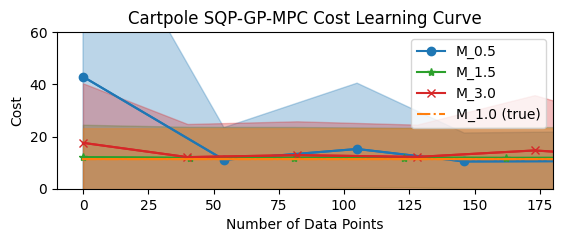

In [10]:
mean, std = M_500.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_0.5', color=colors[0], marker='o')
plt.plot(mean[:, 0], mean[:, 1], color=colors[0])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[0])
mean, std = M_1500.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.5', color=colors[2], marker='*')
plt.plot(mean[:, 0], mean[:, 1], color=colors[2])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[2])
mean, std = M_3000.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_3.0', color=colors[3], marker='x')
plt.plot(mean[:, 0], mean[:, 1], color=colors[3])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[3])
mean, std = M_1000.get_mean_std()
plt.plot(mean[:, 0], mean[:, 1], label='M_1.0 (true)', color=colors[1], linestyle='-.')
plt.plot(mean[:, 0], mean[:, 1], color=colors[1])
plt.fill_between(mean[:, 0], mean[:, 1]-s*std, mean[:, 1]+s*std, alpha=0.3, \
                 color=colors[1])

ax = plt.gca()
# limit the y axis to 0- 100
# plt.ylim(0, None)
plt.ylim(0, 60)
plt.xlim(-10, 180)
plt.xlabel('Number of Data Points')
plt.ylabel('Cost')
plt.title('Cartpole SQP-GP-MPC Cost Learning Curve')
plt.legend()

# change the plot ratio to 4:3
ax.set_aspect(aspect=1.0)

prior data M_0.1 folder exists
max seed 15
csv file for seed 2 does not exist
csv file for seed 3 does not exist
csv file for seed 4 does not exist
csv file for seed 6 does not exist
csv file for seed 7 does not exist
csv file for seed 8 does not exist
csv file for seed 9 does not exist
csv file for seed 10 does not exist
csv file for seed 12 does not exist
csv file for seed 13 does not exist
sim_epoch 6
seed 0 early stop with epoch 2
seed 2 early stop with epoch 0
seed 3 early stop with epoch 0
seed 4 early stop with epoch 0
seed 5 early stop with epoch 2
seed 6 early stop with epoch 0
seed 7 early stop with epoch 0
seed 8 early stop with epoch 0
seed 9 early stop with epoch 0
seed 10 early stop with epoch 0
seed 11 early stop with epoch 2
seed 12 early stop with epoch 0
seed 13 early stop with epoch 0
seed 14 early stop with epoch 4
prior data M_0.5 folder exists
max seed 15
csv file for seed 7 does not exist
csv file for seed 14 does not exist
sim_epoch 6
seed 1 early stop with epoc

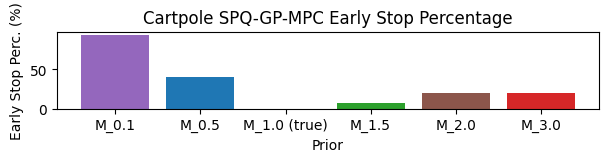

In [11]:
# plot the early stop percentage
plt.figure(figsize=(7, 1))
max_seed = M_500.max_seed


# prior_list = ['M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_3.0']
# for i, data in enumerate(data_list):
#     print(f'prior {prior_list[i]} early stop percentage: {data.early_stop_ratio}')
#     plt.bar(prior_list[i], data.early_stop_ratio * 100, color=colors[i])

# prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
prior_list = ['M_0.1', 'M_0.5', 'M_1.0', 'M_1.5', 'M_2.0', 'M_3.0']
data_list = []
for prior in prior_list:
    data = benchmark_cost_data(data_folder_path, controller_name, prior)
    data_list.append(data)
prior_list = ['M_0.1', 'M_0.5', 'M_1.0 (true)', 'M_1.5', 'M_2.0', 'M_3.0']
plt.bar(prior_list[0], data_list[0].early_stop_ratio * 100, color=colors[4]) # M_0.1
plt.bar(prior_list[1], data_list[1].early_stop_ratio * 100, color=colors[0]) # M_0.5
plt.bar(prior_list[2], data_list[2].early_stop_ratio * 100, color=colors[1]) # M_1.0
plt.bar(prior_list[3], data_list[3].early_stop_ratio * 100, color=colors[2]) # M_1.5
plt.bar(prior_list[4], data_list[4].early_stop_ratio * 100, color=colors[5]) # M_2.0
plt.bar(prior_list[5], data_list[5].early_stop_ratio * 100, color=colors[3]) # M_3.0
plt.xlabel('Prior')
plt.ylabel('Early Stop Perc. (%)')
plt.title('Cartpole SPQ-GP-MPC Early Stop Percentage')

ax=plt.gca()
# change the plot ratio to 4:3
# ax.set_aspect(aspect=3.0)
# save the figure
plt.savefig('cartpole_gp_mpc_early_stop.png', dpi=300)
